In [29]:
import pandas as pd

df = pd.read_csv('./data/sku_sales.csv')
df['order_time'] = pd.to_datetime(df['order_time'])

In [30]:
df.head()

,order_id,store_id,sku_id,order_time,quantity,channel
0,202108310100005,1,317,2021-08-31 00:00:05,1.0,2
1,202108310100023,1,317,2021-08-31 00:00:23,2.0,2
2,202204260100049,1,317,2022-04-26 00:00:49,2.0,2
3,202207040100048,1,317,2022-07-04 00:00:48,2.0,2
4,202207060100029,1,317,2022-07-06 00:00:29,1.0,2


In [31]:
# 将df的order_time列处理成只包含天的日期
df['order_time'] = df['order_time'].dt.date
df.head()

,order_id,store_id,sku_id,order_time,quantity,channel
0,202108310100005,1,317,2021-08-31,1.0,2
1,202108310100023,1,317,2021-08-31,2.0,2
2,202204260100049,1,317,2022-04-26,2.0,2
3,202207040100048,1,317,2022-07-04,2.0,2
4,202207060100029,1,317,2022-07-06,1.0,2


In [81]:
# 将df按照store_id, sku_id, order_time, channel进行分组，然后对每个分组进行聚合，计算每个分组的销量
temp = df.groupby(['store_id', 'sku_id', 'order_time', 'channel']).agg({'quantity': 'sum'}).reset_index()
temp

,store_id,sku_id,order_time,channel,quantity
0,1,1,2022-05-23,2,1.0
1,1,1,2022-05-28,2,3.0
2,1,1,2022-05-29,2,2.0
3,1,1,2022-05-30,2,1.0
4,1,1,2022-05-31,2,1.0
...,...,...,...,...,...
4130680,12,1000,2023-08-27,2,1.0
4130681,12,1000,2023-08-28,2,1.0
4130682,12,1000,2023-08-29,2,2.0
4130683,12,1000,2023-08-31,1,1.0


In [82]:
# 将channel=1的数据过滤出来，然后将其重命名为x_k
x_k = temp[temp['channel'] == 1].rename(columns={'quantity': 'x_k'})

# 将channel=2的数据过滤出来，然后将其重命名为x_m
x_m = temp[temp['channel'] == 2].rename(columns={'quantity': 'x_m'})

# 将x_k和x_m进行合并，合并的时候，将store_id，sku_id，order_time作为合并的键
x = pd.merge(x_k, x_m, on=['store_id', 'sku_id', 'order_time'], how='outer').drop(columns=['channel_x', 'channel_y'])

In [83]:
x = x[x['order_time'] >= pd.to_datetime('2023-08-18').date()]
x

,store_id,sku_id,order_time,x_k,x_m
174,1,1,2023-08-19,3.0,NaN
175,1,1,2023-08-22,1.0,NaN
176,1,1,2023-08-24,4.0,1.0
177,1,1,2023-08-26,3.0,NaN
178,1,1,2023-08-27,8.0,3.0
...,...,...,...,...,...
2751318,12,998,2023-08-23,NaN,1.0
2751319,12,998,2023-08-27,NaN,2.0
2751320,12,998,2023-08-30,NaN,1.0
2751321,12,1000,2023-08-28,NaN,1.0


In [84]:
# store_id从1-12，sku_id从1-1000，order_time从2023-08-18到2023-08-31
store_ids = list(range(1, 13))
sku_ids = list(range(1, 1001))
order_times = pd.date_range('2023-08-18', '2023-08-31').date

# 生成store_id, sku_id, order_time的笛卡尔积
cartesian = pd.MultiIndex.from_product([store_ids, sku_ids, order_times], names=['store_id', 'sku_id', 'order_time'])
cartesian = pd.DataFrame(cartesian.to_frame(), columns=['store_id', 'sku_id', 'order_time']).reset_index(drop=True)

# 将x和cartesian进行合并，合并的时候，将store_id，sku_id，order_time作为合并的键
x = pd.merge(x, cartesian, on=['store_id', 'sku_id', 'order_time'], how='outer').fillna(0)
x

,store_id,sku_id,order_time,x_k,x_m
0,1,1,2023-08-19,3.0,0.0
1,1,1,2023-08-22,1.0,0.0
2,1,1,2023-08-24,4.0,1.0
3,1,1,2023-08-26,3.0,0.0
4,1,1,2023-08-27,8.0,3.0
...,...,...,...,...,...
167995,12,1000,2023-08-21,0.0,0.0
167996,12,1000,2023-08-22,0.0,0.0
167997,12,1000,2023-08-23,0.0,0.0
167998,12,1000,2023-08-24,0.0,0.0


<AxesSubplot: xlabel='order_time'>

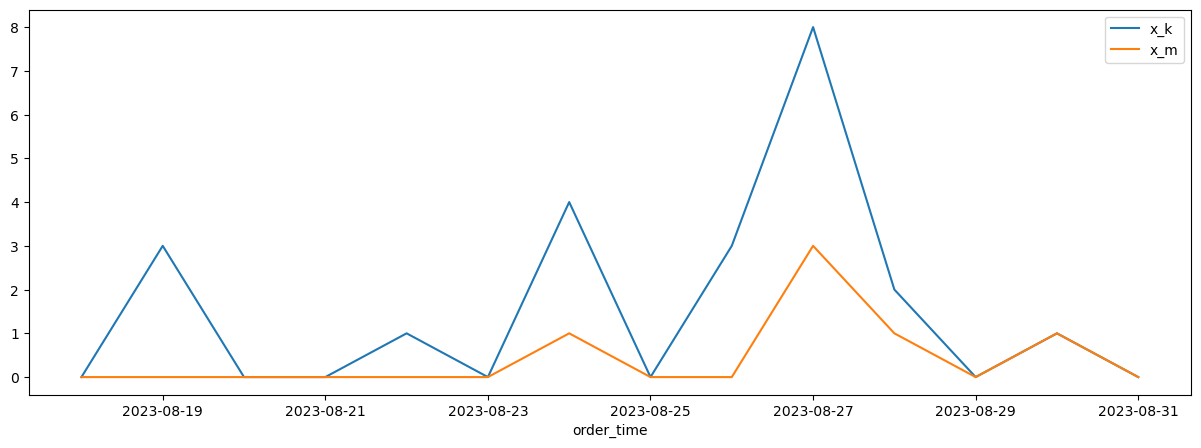

In [85]:
# 筛选出store_id=1, sku_id=1的数据
# 查看其x_k, x_m随时间的变化
x[(x['store_id'] == 1) & (x['sku_id'] == 1)].plot(x='order_time', y=['x_k', 'x_m'], figsize=(15, 5))


In [86]:
# 将order_time列名称改为date
x = x.rename(columns={'order_time': 'date'})
x.head()

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-08-19,3.0,0.0
1,1,1,2023-08-22,1.0,0.0
2,1,1,2023-08-24,4.0,1.0
3,1,1,2023-08-26,3.0,0.0
4,1,1,2023-08-27,8.0,3.0


In [87]:
# 将x的date从2023-09-18到2023-08-31处理成2023-09-01到2023-09-14
x['date'] = x['date'] + pd.Timedelta(days=14)
x.head()

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-02,3.0,0.0
1,1,1,2023-09-05,1.0,0.0
2,1,1,2023-09-07,4.0,1.0
3,1,1,2023-09-09,3.0,0.0
4,1,1,2023-09-10,8.0,3.0


In [88]:
# 按照store_id, sku_id, date排序
x = x.sort_values(by=['store_id', 'date', 'sku_id']).reset_index(drop=True)
x.head()

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,0.0,0.0
1,1,2,2023-09-01,1.0,3.0
2,1,3,2023-09-01,7.0,2.0
3,1,4,2023-09-01,0.0,0.0
4,1,5,2023-09-01,13.0,0.0


In [ ]:
x['x_k'] = (x['x_k'] + x['x_m']) * 1.5 + (x['x_k'] + x['x_m'] == 0) * 4
x['x_m'] = 0

In [55]:
# 将x保存到csv文件中，且不保存index，且将小数点后面的位数保留两位
x.to_csv('./test/test_result.csv', index=False, float_format='%.2f')

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-02,3.0,0.0
1,1,1,2023-09-05,1.0,0.0
2,1,1,2023-09-07,4.0,1.0
3,1,1,2023-09-09,3.0,0.0
4,1,1,2023-09-10,8.0,3.0


In [78]:
# 将x保存到csv文件中，且不保存index，且将小数点后面的位数保留两位
x.to_csv('./test/test_result.csv', index=False, float_format='%.2f')

In [76]:
# 将x中每一个店铺，每一个商品的x_k=0的数据与其他日期的x_k取max
x['x_k'] = x.groupby(['store_id', 'sku_id'])['x_k'].transform(lambda x: x.replace(0, x.max()))

AttributeError: 'Series' object has no attribute 'average'

In [77]:
# 对所有的x_m有不超过0.15的概率变为x_k的0.3倍
import numpy as np
x['x_m'] = np.where(np.random.random(len(x)) < 0.15, x['x_k'] * 0.3, x['x_m'])
x

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,16.5,0.0
1,1,1,2023-09-02,4.5,0.0
2,1,1,2023-09-03,16.5,0.0
3,1,1,2023-09-04,16.5,0.0
4,1,1,2023-09-05,1.5,0.0
...,...,...,...,...,...
167995,12,1000,2023-09-10,3.0,0.0
167996,12,1000,2023-09-11,3.0,0.0
167997,12,1000,2023-09-12,6.0,0.0
167998,12,1000,2023-09-13,6.0,0.0


In [58]:
# 按照store_id, sku_id, date排序
x = x.sort_values(by=['store_id', 'sku_id', 'date']).reset_index(drop=True)

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,0.0,0.0
1,1,1,2023-09-02,3.0,0.0
2,1,1,2023-09-03,0.0,0.0
3,1,1,2023-09-04,0.0,0.0
4,1,1,2023-09-05,1.0,0.0
...,...,...,...,...,...
167995,12,1000,2023-09-10,1.0,1.0
167996,12,1000,2023-09-11,0.0,1.0
167997,12,1000,2023-09-12,0.0,2.0
167998,12,1000,2023-09-13,0.0,0.0


In [61]:
# 检测是否满足x_k + x_m > 0时x_k>0，将这些不符合条件的数据过滤出来x_k置为x_k + x_m
x.loc[(x['x_k'] + x['x_m'] > 0) & (x['x_k'] <= 0), 'x_k'] = x['x_k'] + x['x_m']

In [70]:
x['x_k'] = (x['x_k'] + x['x_m']) * 1.5
x['x_m'] = 0

In [79]:
# 检测是否满足对于每个store_id和date，(x_k + x_m > 0的数量) * 0.2 >= (x_m > 0的数量)

# 按照store_id, date分组，然后对每个分组进行聚合，计算每个分组的x_k + x_m > 0的数量
temp = x.groupby(['store_id', 'date']).agg({'x_k': lambda x: (x > 0).sum()}).reset_index()
temp = temp.rename(columns={'x_k': 'count_x_k'})

# 按照store_id, date分组，然后对每个分组进行聚合，计算每个分组的x_m > 0的数量
temp = pd.merge(temp, x.groupby(['store_id', 'date']).agg({'x_m': lambda x: (x > 0).sum()}).reset_index(), on=['store_id', 'date'], how='left')
temp = temp.rename(columns={'x_m': 'count_x_m'})

# 检测是否满足对于每个store_id和date，(x_k + x_m > 0的数量) * 0.2 >= (x_m > 0的数量)
temp['check'] = temp['count_x_k'] * 0.2 >= temp['count_x_m']

In [80]:
temp['check'].value_counts()

check
True    168
Name: count, dtype: int64

In [66]:
temp

,store_id,date,count_x_k,count_x_m,check
0,1,2023-09-01,601,361,False
1,1,2023-09-02,669,406,False
2,1,2023-09-03,648,407,False
3,1,2023-09-04,583,328,False
4,1,2023-09-05,608,349,False
...,...,...,...,...,...
163,12,2023-09-10,809,583,False
164,12,2023-09-11,711,501,False
165,12,2023-09-12,746,508,False
166,12,2023-09-13,756,536,False
